In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
%matplotlib inline

In [2]:
# Load
X = np.load('/home/filsave/malviso/X.npy', allow_pickle=True)
y = np.load('/home/filsave/malviso/y.npy', allow_pickle=True)

In [3]:
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [4]:
import numpy as np
from PIL import Image

def gabor_filter(ksize, sigma, theta, lambd, gamma, psi):
    filter_kernel = cv2.getGaborKernel((ksize, ksize), sigma, theta, lambd, gamma, psi, cv2.CV_32F)
    return filter_kernel

def apply_gabor_filter(img, filter_kernel):
    filtered_img = cv2.filter2D(img, cv2.CV_8UC3, filter_kernel)
    return filtered_img

def extract_features(filtered_img):
    mean = np.mean(filtered_img)
    var = np.var(filtered_img)
    feature_vector = np.concatenate((np.array([mean]), np.array([var])))
    return feature_vector

def Gabor_filter_extraction(img):
    # Define the parameters for the 24 Gabor filters
    ksize = 5
    sigma_list = [1, 2, 3]
    theta_list = [0, np.pi/8, np.pi/4, 3*np.pi/8]
    lambd_list = [0.05, 0.25]
    gamma = 0.5
    psi = 0.0

    filtered_img_list = []
    for sigma in sigma_list:
        for theta in theta_list:
            for lambd in lambd_list:
                # Create the filter kernel
                filter_kernel = gabor_filter(ksize, sigma, theta, lambd, gamma, psi)
                # Apply the filter to the image
                filtered_img = apply_gabor_filter(img, filter_kernel)
                filtered_img_list.append(filtered_img)
    feature_vector = []
    for i, filtered_img in enumerate(filtered_img_list):
      filtered_img = cv2.normalize(filtered_img, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8UC1)
      features = extract_features(filtered_img)
      feature_vector.append(features)

    hist = cv2.calcHist([img], [0], None, [16], [0, 256])
    feature_vector.append(hist)
    return feature_vector


In [5]:
total_des_test = [Gabor_filter_extraction(img) for img in X_test] 

total_des_train = [Gabor_filter_extraction(img) for img in X_train] 

# reshape the filters
tot_train_features = []

for i in total_des_train:
  x = np.hstack(i[:24])
  z = i[-1].flatten()
  w = np.concatenate((x,z))
  tot_train_features.append(w)


tot_test_features = []

for i in total_des_test:
  x = np.hstack(i[:24])
  z = i[-1].flatten()
  w = np.concatenate((x,z))
  tot_test_features.append(w)

In [6]:
tot_train_features = np.array(tot_train_features)

tot_test_features = np.array(tot_test_features)

Mean accuracy:  0.8721264777097281
Standard deviation:  0.04616871109413196


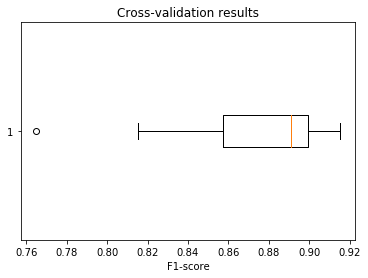

In [7]:
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier

# Define the parameters to search
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 4, 8],
    'min_samples_leaf': [1, 2, 4]
}

# Create an instance of the RandomForestClassifier
clf = RandomForestClassifier(random_state=42)

# Create an instance of GridSearchCV
grid_search = GridSearchCV(clf, param_grid, cv=10)

# Fit the grid search to the data
grid_search.fit(tot_train_features, y_train)

# Get the best parameters
best_params = grid_search.best_params_

# Get the best classifier
best_clf = grid_search.best_estimator_

# Use cross_val_score to evaluate the classifier with the best parameters
scores = cross_val_score(best_clf, tot_test_features, y_test, cv=10)

# Print the mean and standard deviation of the scores
print("Mean accuracy: ", scores.mean())
print("Standard deviation: ", scores.std())

# Plot the results as a box plot
plt.boxplot(scores, vert=False)
plt.xlabel("F1-score")
plt.title("Cross-validation results")
plt.show()

If everything goes fine, I plotted the wrong x label, as this is the "accuracy" scoring. Needed editing in post production in case